In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil

In [19]:
import kagglehub
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

Path to dataset files: C:\Users\mural\.cache\kagglehub\datasets\emmarex\plantdisease\versions\1


In [14]:
selected_tomatoes = [
    "Tomato_healthy",
    "Tomato_Early_blight",
    "Tomato_Late_blight",
    "Tomato_Bacterial_spot"
]

all_classes = sorted(os.listdir(source_root))
potato = [c for c in all_classes if c.lower().startswith("potato")]
pepper = [c for c in all_classes if c.lower().startswith("pepper")]

final_classes = selected_tomatoes + potato + pepper
print("Classes used =", final_classes)

Classes used = ['Tomato_healthy', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_Bacterial_spot', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy']


In [15]:
clean_dir = "MultiCrop_9"
if not os.path.exists(clean_dir):
    os.makedirs(clean_dir)

    for cls in final_classes:
        src = os.path.join(source_root, cls)
        dst = os.path.join(clean_dir, cls)
        if os.path.exists(src):
            shutil.copytree(src, dst)
else:
    print("Dataset folder already exists; skipping copy.")

print("Prepared dataset folder:", clean_dir)

Prepared dataset folder: MultiCrop_9


In [20]:
# Train / Validation
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    clean_dir,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    clean_dir,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = train_ds.class_names
print("Detected classes:", class_names)

# Split val into val + test
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches // 2)
val_ds = val_ds.skip(val_batches // 2)

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

Found 11254 files belonging to 9 classes.
Using 9004 files for training.
Found 11254 files belonging to 9 classes.
Using 2250 files for validation.
Detected classes: ['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']


In [21]:
def build_mobilenet(num_classes):
    base = tf.keras.applications.MobileNetV2(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3)
    )
    base.trainable = False  # freeze

    inputs = layers.Input(shape=(224, 224, 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = models.Model(inputs, outputs)
    return model

num_classes = len(class_names)
model = build_mobilenet(num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ true_divide (TrueDivide)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ subtract (Subtract)                  │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 9)                   │          11,529 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,269,513 (8.66 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [22]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 269s 928ms/step - accuracy: 0.3029 - loss: 2.0178 - val_accuracy: 0.7487 - val_loss: 1.0418
Epoch 2/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 206s 732ms/step - accuracy: 0.6693 - loss: 1.0548 - val_accuracy: 0.8336 - val_loss: 0.6742
Epoch 3/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 195s 693ms/step - accuracy: 0.7887 - loss: 0.7193 - val_accuracy: 0.8584 - val_loss: 0.5287
Epoch 4/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 198s 701ms/step - accuracy: 0.8240 - loss: 0.5767 - val_accuracy: 0.8858 - val_loss: 0.4337
Epoch 5/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 217s 771ms/step - accuracy: 0.8545 - loss: 0.4820 - val_accuracy: 0.8894 - val_loss: 0.3856
Epoch 6/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 206s 729ms/step - accuracy: 0.8694 - loss: 0.4279 - val_accuracy: 0.9044 - val_loss: 0.3455
Epoch 7/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 205s 726ms/step - accuracy: 0.8846 - loss: 0.3867 - val_accuracy: 0.9097 - val_loss: 0.3131
Epoch 8/10
282/282 ━━━━━━━━━━━━━━━━━━━━ 212s 751ms/step - accuracy: 0.8942 -

In [23]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test Accuracy =", test_acc)

35/35 ━━━━━━━━━━━━━━━━━━━━ 21s 600ms/step - accuracy: 0.9395 - loss: 0.2371
Test Accuracy = 0.9348214268684387


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 604ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 608ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 579ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 633ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 584ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 572ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 611ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 641ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 590ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 622ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

<Figure size 1000x1000 with 0 Axes>

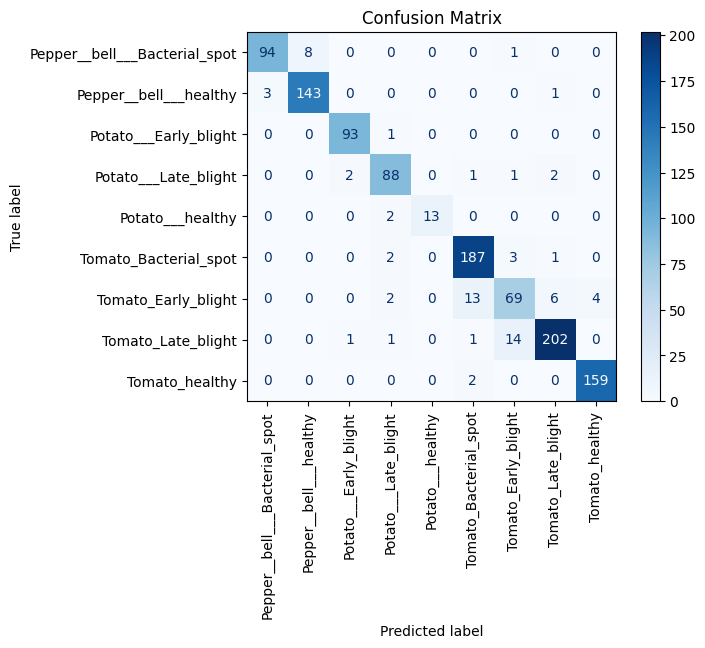

In [24]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

plt.figure(figsize=(10,10))
disp.plot(xticks_rotation='vertical', cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [26]:
model.save("plant_model.keras")
print("Saved")

Saved
